In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
% matplotlib inline
#check to see if I can control how big each holdout set is, do with rms error
from sklearn.cross_validation import cross_val_score as cvs
from sklearn.cross_validation import KFold

#Import Data

In [374]:
df_all = pd.io.parsers.read_csv(filepath_or_buffer = 'F6_clean_features.csv', parse_dates = [0], index_col = 0)
print df_all[:5]

                       O3_ppb      UnixTime      e2v03    Temp         Rh  \
DATE (MM/DD/YYYY)_MST                                                       
2014-07-11 03:30:00        31  1.405049e+09  71.560000  32.200  25.232000   
2014-07-11 03:31:00        30  1.405049e+09  64.200000  32.200  24.976000   
2014-07-11 03:32:00        29  1.405050e+09  61.960000  32.200  24.996000   
2014-07-11 03:33:00        26  1.405050e+09  59.640000  32.132  25.128000   
2014-07-11 03:34:00        22  1.405050e+09  55.423077  32.100  25.242308   

                       Zenith Angle [degrees]  days from start  ref_o3_smooth  \
DATE (MM/DD/YYYY)_MST                                                           
2014-07-11 03:30:00                 102.04297                0             31   
2014-07-11 03:31:00                 101.90141                0             30   
2014-07-11 03:32:00                 101.75942                0             29   
2014-07-11 03:33:00                 101.61701          

###Delete the unfiltered data

In [375]:
#df_all.drop(df_all.columns[[1,5]], axis=1, inplace=True)
#print df_all[:5]

##Declare whether to process raw or filtered data.

In [376]:
which_data = 0    #1 = filtered, 0 = raw
if which_data == 1:
    ref_column = 'O3_ppb'
    leave_out_pod = 'e2v03'
else:
    ref_column = 'ref_o3_smooth'
    leave_out_pod = 'pod_o3_smooth'

#Forward Selection

In [377]:
import random
import sys
from scipy import stats
from sklearn import linear_model

###Evaluate Critical Function

In [378]:
#make numpy arrays out of the training and holdout data
def df_subset(features, df_F, df_H):
    X_F = df_F[features].values
    X_H = df_H[features].values
    y_F = df_F[ref_column].values
    y_H = df_H[ref_column].values
    return X_F, y_F, X_H, y_H

#fits lin reg and finds RSS
def crit_func(features, df_F, df_H):
    regr = linear_model.LinearRegression()
    #call the df_subset function to make numpy arrays out of the training and holdout data
    X_F, y_F, X_H, y_H = df_subset(features, df_F, df_H)
    #fit a linear regression on the training data
    regr.fit(X_F, y_F)
    #find the normalized RSS for the training and holdout data
    return sum((y_H - regr.predict(X_H)) ** 2)/len(y_H), sum((y_F - regr.predict(X_F)) ** 2)/len(y_F)

###Forward-selection using leave-one-day-out cross validation:

In [379]:
#define function that iteratively adds remaining features to best features to see which is most important
def forward_selection_step(b_f, features, df_F, df_H):
    #initialize min_RSS with a very large number
    min_RSS = sys.maxint
    next_feature = ''
    for f in features:
        #call the func that finds RSS, using arguments it's called with. First argument is best features + whichever one 
        #we're on in this iteration.
        RSS_H, RSS_F = crit_func(b_f + [f], df_F, df_H)
        if RSS_H < min_RSS:
            min_RSS = RSS_H
            next_feature = f
    return next_feature

In [380]:
def forward_selection_lodo(features, df):
    #initialize the best_features list with the base features to force their inclusion
    best_features = []
    #create a 'day' column in the dataframe by mapping the index column
    df['day'] = df.index.map(lambda dt: str(dt.month) + '-' + str(dt.day))
    days = df['day'].unique()
    
    RSS_F_list = []
    RSS_H_list = []
    while len(features) > 0:
        next_features = []
        #loop through every single day for the cross-validation
        for d in days:
            #Leave-one-out cross-validation. third agrument is training days (not selected day), fourth is holdout day. 
            f = forward_selection_step(best_features, features, df[df.day != d], df[df.day == d])
            #forward_selection_step returns the next feature, which is added to the next-features list. For every day, 
            #a different possible best feature is chosen, and they're all put in this list
            next_features += [f]
        #take the mode of the best features list from all cross-validation days (vote)
        next_feature = stats.mode(next_features)[0][0]
        #add the chosed best feature to the list
        best_features += [next_feature]
        #remove the chosen feature from the list
        features.remove(next_feature)
        
        #prints the result of the vote- shows you how many days voted for that feature
        print stats.mode(next_features)
        
        #initizlize the holdout and training RSS
        RSS_H = 0
        RSS_F = 0

        #So that we can plot them below, calculate the training and holdout RSS for each step.
        #take the mean RSS for all of the possible holdout days (giving cross-validation error)
        for d in days:
            RSS_H_temp, RSS_F_temp= crit_func(best_features, df[df.day != d], df[df.day == d])
            RSS_H += int(RSS_H_temp)
            RSS_F += int(RSS_F_temp)

            
        RSS_H_list += [RSS_H / len(days)]
        RSS_F_list += [RSS_F / len(days)]

    #drop the day column
    df.drop('day', axis=1, inplace=True)
    return best_features, RSS_F_list, RSS_H_list

##Try it!

In [381]:
#make a list of features from the column titles in the dataframe
features = list(df_all.columns)
#this lets you leave out anything you want
leave_out = ['O3_ppb','Zenith Angle [degrees]','UnixTime','days from start','ref_o3_smooth', leave_out_pod]
features = [f for f in features if f not in leave_out]

In [382]:
fs_features, RSS_F, RSS_H = forward_selection_lodo(features, df_all[[ref_column]+features].dropna())
print fs_features

(array(['ln_03_mult_rh'], 
      dtype='|S32'), array([ 4.]))
(array(['ln_temp_mult_rh'], 
      dtype='|S32'), array([ 4.]))
(array(['rh_sq'], 
      dtype='|S32'), array([ 4.]))
(array(['03_mult_rh'], 
      dtype='|S32'), array([ 3.]))
(array(['rh_cu'], 
      dtype='|S32'), array([ 4.]))
(array(['03_mult_rh_sq'], 
      dtype='|S32'), array([ 2.]))
(array(['Rh'], 
      dtype='|S32'), array([ 3.]))
(array(['temp_cu'], 
      dtype='|S32'), array([ 3.]))
(array(['03_mult_rh_cu'], 
      dtype='|S32'), array([ 3.]))
(array(['Temp'], 
      dtype='|S32'), array([ 4.]))
(array(['ln_rh_int_90'], 
      dtype='|S32'), array([ 4.]))
(array(['e2v03'], 
      dtype='|S32'), array([ 4.]))
(array(['ln_temp_int_90'], 
      dtype='|S32'), array([ 3.]))
(array(['temp_mult_rh_cu'], 
      dtype='|S32'), array([ 4.]))
(array(['temp_int_90'], 
      dtype='|S32'), array([ 4.]))
(array(['O3_sq'], 
      dtype='|S32'), array([ 5.]))
(array(['O3_cu'], 
      dtype='|S32'), array([ 5.]))
(array(['temp

[57, 33, 29, 27, 26, 27, 27, 25, 24, 25, 25, 25, 24, 24, 25, 24, 24, 26, 27, 26, 25, 25, 24, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 29, 28]


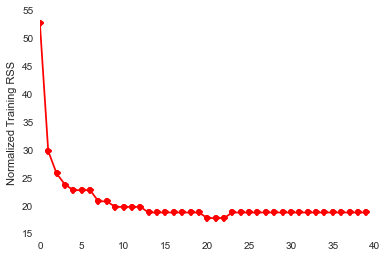

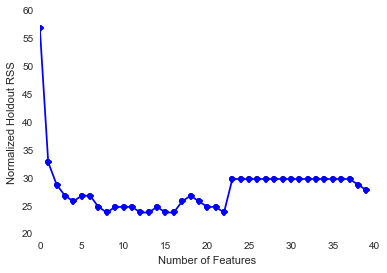

In [383]:
x = range(0, len(RSS_F))
plt.figure()
plt.plot(x, RSS_F, 'ro-')
plt.ylabel('Normalized Training RSS')
plt.figure()
plt.plot(x, RSS_H, 'bo-')
plt.xlabel('Number of Features')
plt.ylabel('Normalized Holdout RSS')
print RSS_H

#Enter the number of good features to use for regressions.

In [384]:
num_good_feat = 9
fs_features[:num_good_feat]

['ln_03_mult_rh',
 'ln_temp_mult_rh',
 'rh_sq',
 '03_mult_rh',
 'rh_cu',
 '03_mult_rh_sq',
 'Rh',
 'temp_cu',
 '03_mult_rh_cu']

#Check Residuals

In [385]:
df_fit = df_all[fs_features[:num_good_feat] + [ref_column]].dropna()
X = df_fit[fs_features[:num_good_feat]].values
y = df_fit[ref_column].values

In [386]:
regr = linear_model.LinearRegression()
regr.fit(X,y)
df_fit['O3_fit'] = regr.predict(X)

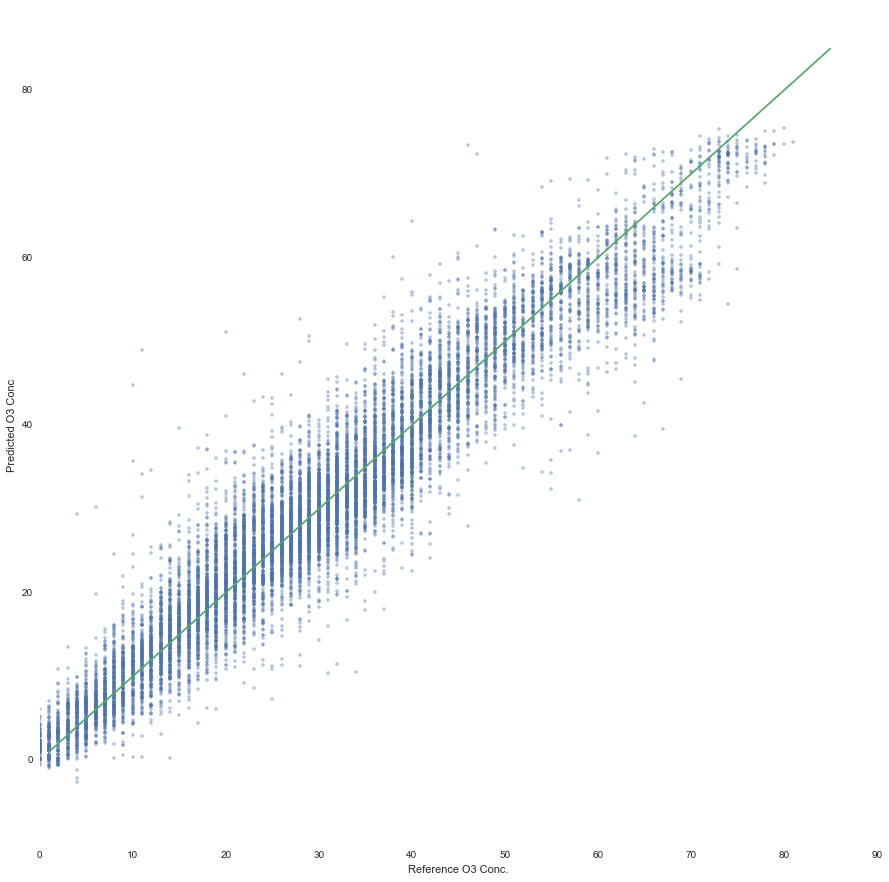

In [387]:
plt.figure(figsize = (15,15))
plt.plot(df_fit[ref_column],df_fit.O3_fit,linestyle = '',marker = '.',alpha = 0.4)
plt.xlabel('Reference O3 Conc.')
plt.ylabel('Predicted O3 Conc')
plt.plot([1,42.5,85],[1,42.5,85])

In [349]:
print ("Residual sum of squares: %.2f" %
        np.mean((df_fit[ref_column] - df_fit.O3_fit) ** 2))

Residual sum of squares: 26.51


In [350]:
#find the residuals
lin_resid = df_fit[ref_column] - df_fit.O3_fit

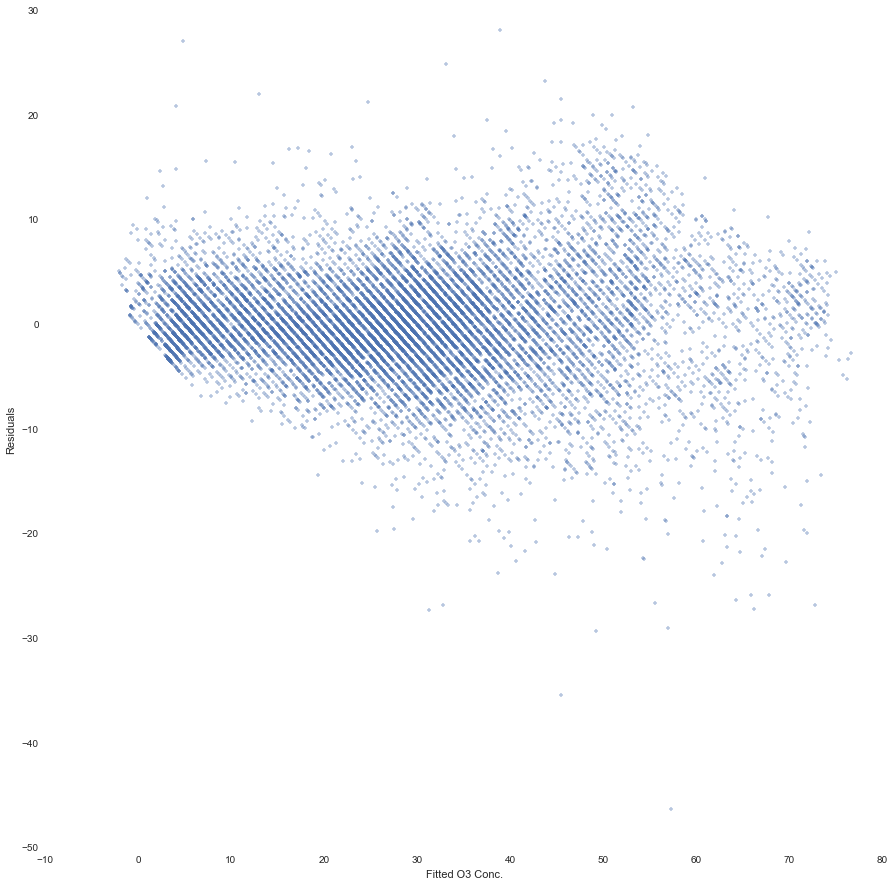

In [351]:
#plot the residuals to check for non-linearity of response predictor
plt.figure(figsize = (15,15))
plt.plot(df_fit.O3_fit,lin_resid,linestyle = '',marker = '.',alpha = 0.4)
#plt.plot([0,0],[70,0])
plt.xlabel('Fitted O3 Conc.')
plt.ylabel('Residuals')

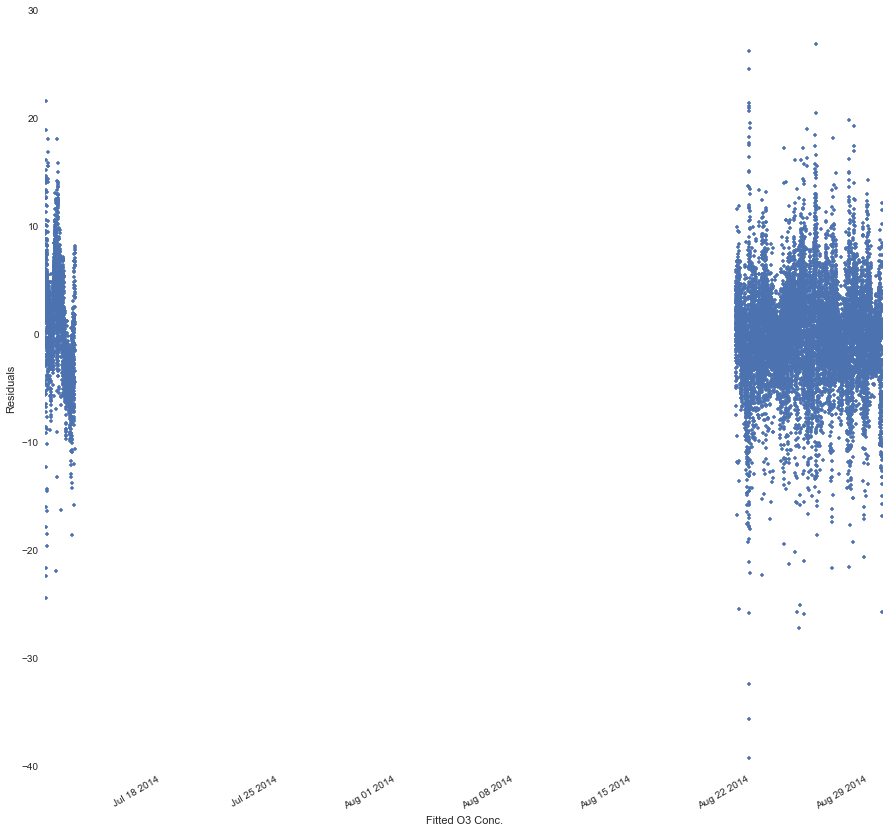

In [185]:
plt.figure(figsize = (15,15))
lin_resid.plot(linestyle = '',marker = '.')
#plt.plot([0,0],[70,0])
plt.xlabel('Fitted O3 Conc.')
plt.ylabel('Residuals')

In [186]:
# Explained variance score: 1 is perfect prediction
print ('Variance score: %.2f' % regr.score(X, y))

Variance score: 0.93


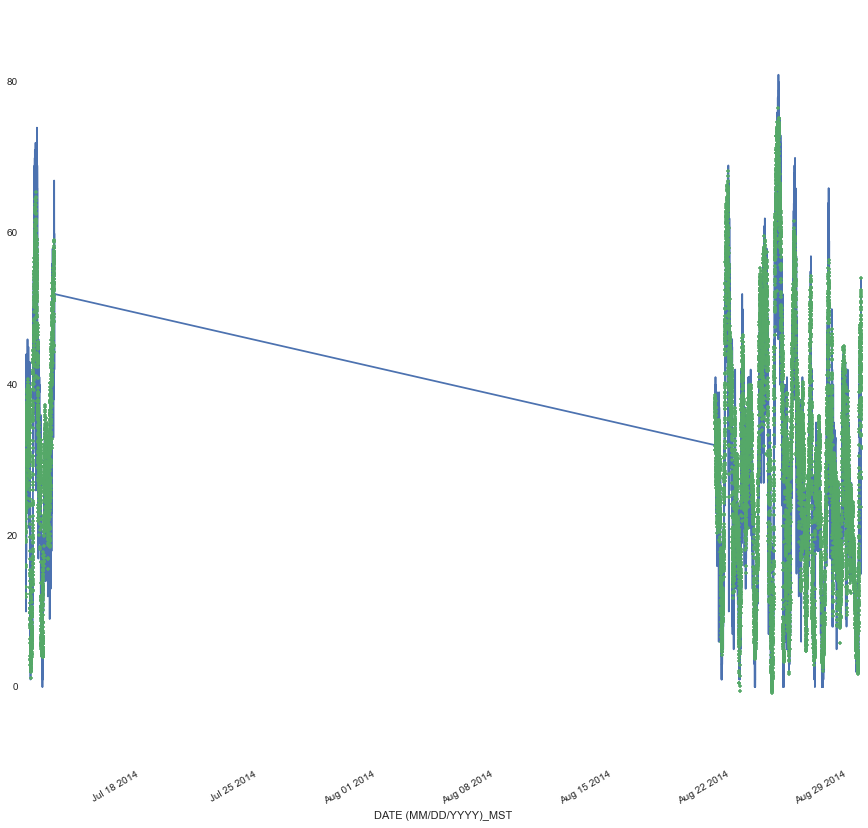

In [187]:
plt.figure(figsize = (15,15))
df_fit[ref_column].plot()
df_fit.O3_fit.plot(marker = '.',linestyle = '')

#Ridge Regression

In [364]:
fs_features = ['e2v03','Temp','Rh']
num_good_feat = len(fs_features)

In [365]:
from sklearn.linear_model import Ridge

#define the training data
df_fit = df_all[fs_features[:num_good_feat] + [ref_column]].dropna()
X = df_fit[fs_features[:num_good_feat]].values
y = df_fit[ref_column].values
#print df_fit[:5]

###Find the best lambda value using cross-validation

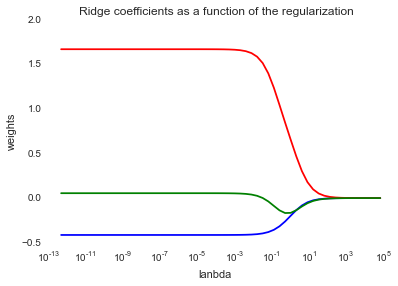

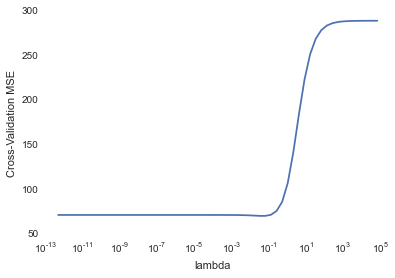

In [366]:
MSE_ridge = []
lambda_ridge = []
i = 0.0000000000005
n = 1
coefs = []
while i < 100000:
    ridge = Ridge(alpha=i, normalize = True)
    #fit the ridge regression for the lambda
    ridge.fit(X, y)
    #get the cross-validation scores
    scores = cvs(ridge, X, y, cv = 10, scoring='mean_squared_error')
    #record the score
    MSE_ridge.append(-scores.mean())
    #record the run number
    lambda_ridge.append(i)    
    coefs.append(ridge.coef_)
    i = i*2
    n += 1
        
#plot the coefficients     
ax = plt.gca()
ax.set_color_cycle(['b', 'r', 'g', 'c', 'k', 'y', 'm'])

ax.plot(lambda_ridge, coefs)
ax.set_xscale('log')
plt.xlabel('lanbda')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.show()  
    
#find the lambda value that produces the lowest cross-validation MSE    
best_lambda = lambda_ridge[MSE_ridge.index(min(MSE_ridge))]

    
#plot the results
plt.plot(lambda_ridge, MSE_ridge)
ax = plt.gca()
ax.set_xscale('log')
plt.xlabel('lambda')
plt.ylabel('Cross-Validation MSE')

####Define a function that finds the ridge regression for each day

In [371]:
#fit random forest and finds RSS
def rand_for_cv(features, df_F, df_H):
    
    #Set up the random forest regression features
    ridge = Ridge(alpha=best_lambda, normalize = True)
    
    #call the r=function that defines the trainig and holdout data
    X_T, y_T, X_H, y_H = df_subset(features, df_fit[df_fit.day != d], df_fit[df_fit.day == d])
    
    #fit a linear regression on the training data
    ridge.fit(X_T, y_T)  
    
    #find the normalized MSE for the training and holdout data
    return np.mean((y_H - ridge.predict(X_H))**2), np.mean((y_T - ridge.predict(X_T))**2)

####Find the MSE by holding out one day 

In [372]:
#define the dataset
df_fit = df_all[fs_features[:num_good_feat] + [ref_column]].dropna()

#create a 'day' column in the dataframe by mapping the index column
df_fit['day'] = df_fit.index.map(lambda dt: str(dt.month) + '-' + str(dt.day))
days = df_fit['day'].unique()
        
#initizlize the holdout and training RSS
MSE_T = []
MSE_H = [] 
day_date = []
count = 1
count_append = []
#Calculate the training and holdout RSS for each step.
#take the mean MSE for all of the possible holdout days (giving cross-validation error)
for d in days:
    MSE_H_temp, MSE_T_temp = rand_for_cv(fs_features[:num_good_feat], df_fit[df_fit.day != d], df_fit[df_fit.day == d])
    MSE_H.append(MSE_H_temp)
    MSE_T.append(MSE_T_temp)
    day_date.append(d)
    count +=1
    count_append.append(count)

#drop the day column
df_fit.drop('day', axis=1, inplace=True)

In [373]:
print 'mean MSE = ' + str(np.mean(MSE_H))
print 'Daily MSE = ' + str(MSE_H)

mean MSE = 72.6207348101
Daily MSE = [111.98581662103034, 35.857340867121984, 69.00498879558063, 42.182169741224904, 42.233361731185539, 218.15619083956918, 79.669580368798194, 42.805670518762291, 59.925185197134297, 47.818659169702741, 49.189119061505934]


In [317]:
ridge.coef_

array([ -8.12801342e-06,   2.81835374e-05,  -7.25012374e-06])

In [370]:
best_lambda = 0

In [602]:
#Set the predictor variable. 
y_pred_ridge = ridge.predict(X)
print y-y_pred_ridge

[ -0.99047452   1.00950577  -0.99048544 ...,   2.00856311  18.00860477
  17.00867731]


In [603]:
#Calculate the training MSE
mse = np.mean((y - y_pred_ridge)**2)
print mse

272.031034816


In [604]:
#make a copy of the reference & pod data to manipulate
df_fit_ridge = df_fit.copy()
df_fit_ridge[:5]

,e2v03,Temp,Rh,ref_o3_smooth
DATE (MM/DD/YYYY)_MST,,,,
2014-07-13 04:21:00,97.000000,24.3,54.833333,29
2014-07-13 04:22:00,94.500000,24.3,54.950000,31
2014-07-13 04:23:00,95.333333,24.3,55.100000,29
2014-07-13 04:24:00,98.000000,24.3,55.066667,26
2014-07-13 04:25:00,100.000000,24.3,55.200000,25


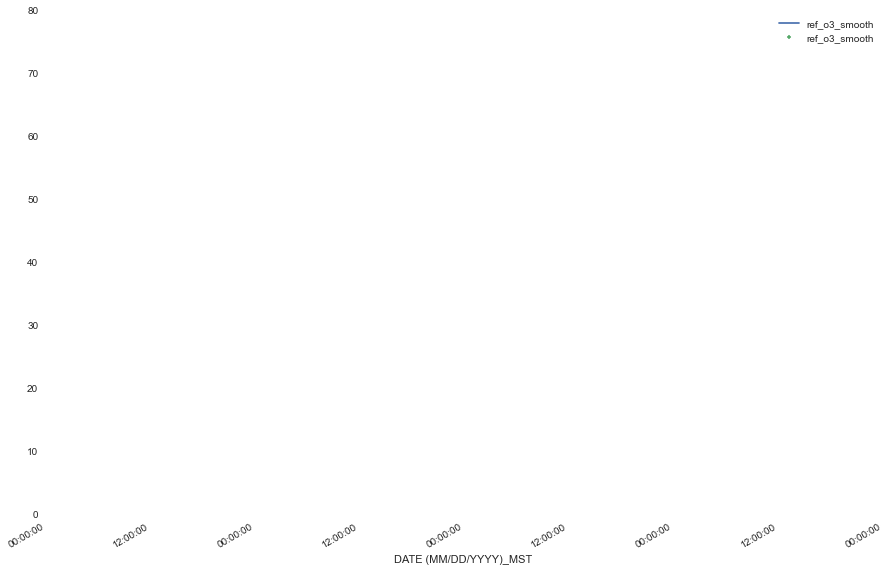

In [605]:
#plot the reference data
df_fit[ref_column].plot(legend = 'true',figsize = (15,10))
#add the predictions to the plot
df_fit_ridge[ref_column].plot(legend = 'true', linestyle = '.',marker = '.', figsize = (15,10), xlim=['2014-07-07 00:00:00', '2014-07-11 00:00:00'])

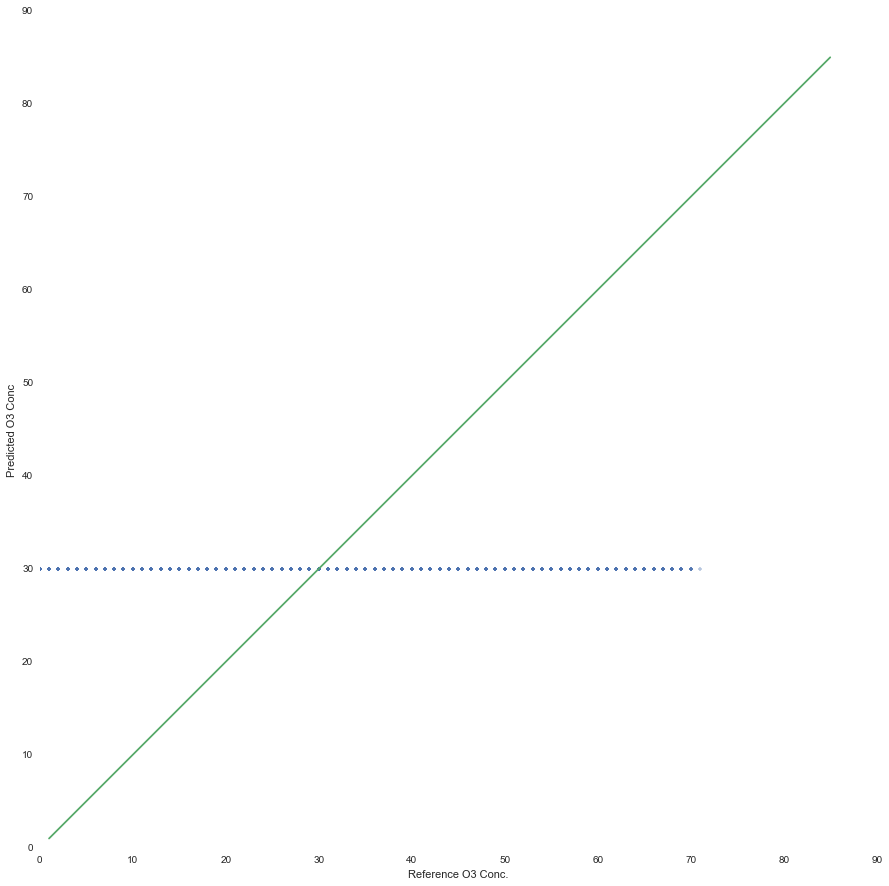

In [606]:
plt.figure(figsize = (15,15))
plt.plot(y,y_pred_ridge,linestyle = '',marker = '.',alpha = 0.4)
plt.xlabel('Reference O3 Conc.')
plt.ylabel('Predicted O3 Conc')
plt.plot([1,42.5,85],[1,42.5,85])

#Linear Regression

In [289]:
from sklearn import datasets, linear_model
regr = linear_model.LinearRegression()

####fit the data using a linear regression model

In [290]:
lin_reg = regr.fit(X, y)

####Print the coefficients


In [291]:
print('Coefficients: \n', regr.coef_)

('Coefficients: \n', array([  1.92241825e+00,  -1.45521807e+00,  -1.97282308e+01,
        -5.86662981e-07,  -5.77278222e-07,   6.39033338e-03,
         1.61787706e-02,  -2.82337506e-03,   4.53303019e-02,
         6.13730089e-05,  -5.28942262e-03,  -2.15747706e-02,
         5.59376824e-05,  -5.26031635e-02,  -6.13235679e-03,
        -1.98074200e-10,  -5.90146090e-07,  -5.90146090e-07,
         6.60564749e-01]))


In [292]:
import sklearn.cross_validation 
# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validated:
predicted = sklearn.cross_validation.cross_val_predict(regr, X, y, cv=10)

AttributeError: 'module' object has no attribute 'cross_val_predict'

In [293]:
#Set the predictor variable. 
lin_pred = lin_reg.predict(X)

#make a copy of the reference & pod data to manipulate
df_lin_pred = df_all.copy()

#change the reference data column in the new matrix to the predicted value
df_lin_pred['O3_ref'] = lin_pred

#plot the reference data
df_all['O3_ref'].plot(legend = 'true',figsize = (15,10))
#add the predictions to the plot
df_lin_pred['O3_ref'].plot(legend = 'true', linestyle = '.',marker = '.', figsize = (15,10))
#plt.show()

KeyError: 'O3_ref'